## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration using chessboard images

In this section we take checkerboard images taken from the camera used to film video for this assignment and use it for calibration. I use cv2.findChessboardCorners to generate objpoints and imgpoints. imgpoints are just 2d coordinates of a flat image. objpoints are represent how these float 2d coordinates are mapped in a 3d space. Both of the these will help us with calibration and ultimately undistort the images that the camera produces. Below I display a set of before and after images with the test set provided.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Use calibrations to undistort images

With objpoints and imgpoints generated in the last step, we pass it into v2.calibrateCamera to essentially give us the camera calibration and distortion coefficients. This enables us to call cv2.undistort to undistort the images the camera generates.

Distorted Set


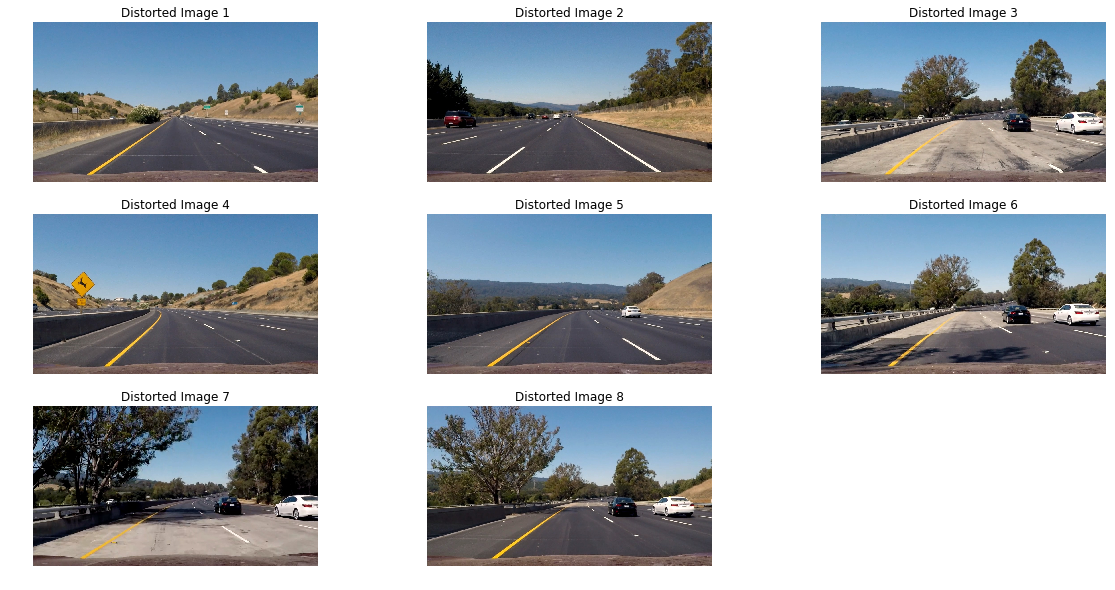

Undistorted Set


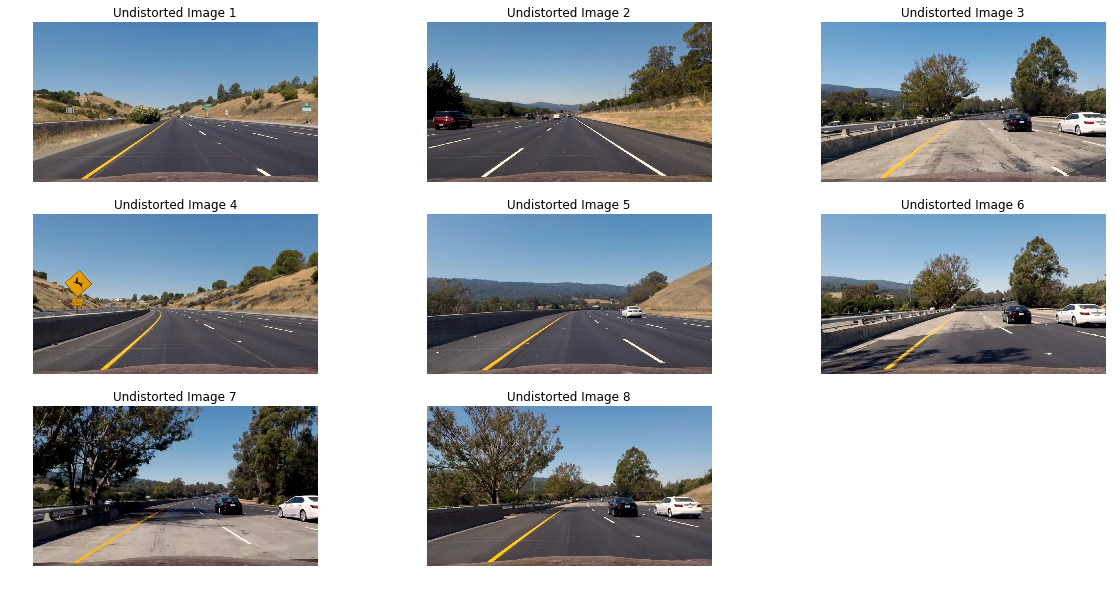

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
# Visualizations will be shown in the notebook.
%matplotlib inline

# Performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    return img

# Visualize effect of calibration and distortion correction
test_images = glob.glob('./test_images/*.jpg')
print("Distorted Set")
plt.figure(figsize=(20,10))
i = 1
for filename in test_images:
    plt.subplot(3, 3, i)
    plt.axis('off')
    plt.title("Distorted Image %s" % i)
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image.squeeze())
    i += 1
plt.show()

print("Undistorted Set")
plt.figure(figsize=(20,10))
i = 1
for filename in test_images:
    plt.subplot(3, 3, i)
    plt.axis('off')
    plt.title("Undistorted Image %s" % i)
    image = cv2.imread(filename)
    image = cal_undistort(image, objpoints, imgpoints)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image.squeeze())
    i += 1
plt.show()

## Perspective Transform

Now that we have images that are free of distortion from the camera lens its time to think about how to accurately measure curvature of the lane lines. When using the images as-is its quite hard to see or measure the curviture of the lane lines - they all generally look like their going straight and pointing inwards. Luckily we can utilize perspective tranform to view the lane lines from a birds-eye view.

To do that I create 2 sets of coordinates to feed into my method perspective_transform that utilizes cv2.warpPerspective - src and dst. src is a set of coordinates (4) that forms a trapezoid that map to the lane lines. dst is a set of coordinates (4) of where we want to warp the lane line coordinates to to achieve a birds-eye view. 

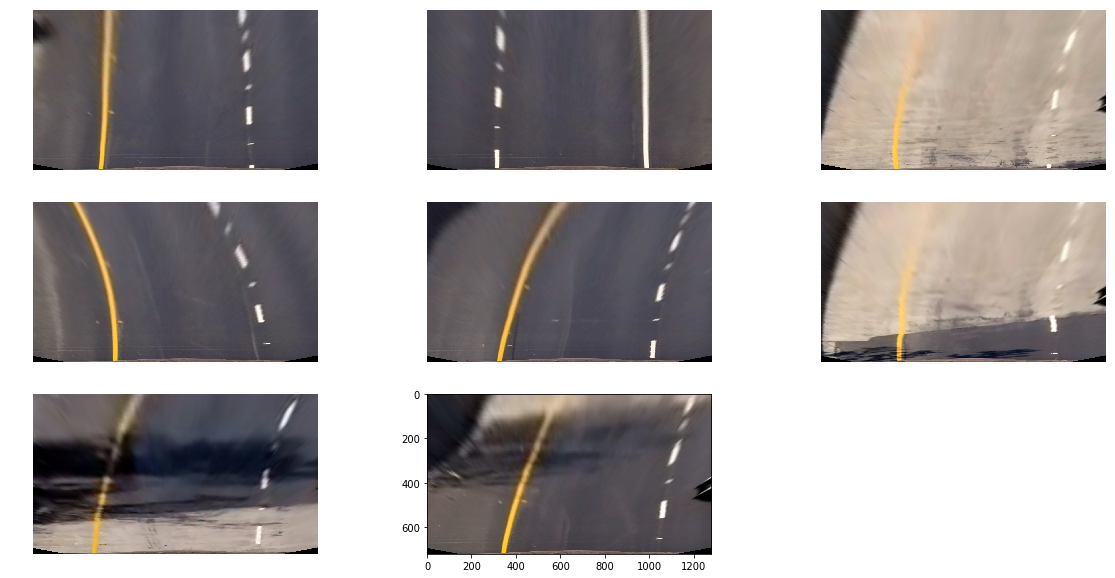

In [4]:
def perspective_trasform(image, src, dst):
    # Grab the image shape
    img_size = (image.shape[1], image.shape[0])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Inverse
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

    # Return the resulting image and matrix
    return warped, M, Minv

# Lets test this out and see what the perspective transform looks like. Goal it to achive parallel lines! 
plt.figure(figsize=(20,10))
i = 1
offset = 300
for filename in test_images:
    image = cv2.imread(filename)
    
    # Calling our calibration function first
    image = cal_undistort(image, objpoints, imgpoints)
    img_size = (image.shape[1], image.shape[0])
    # Arbitrarily picked coordinates from image to form mask
    src = np.float32([[590, 450], [690, 450], [1100, 720], [200, 720]])
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                     [img_size[0]-offset, img_size[1]],[offset, img_size[1]]]) 
    
    image, M, Minv = perspective_trasform(image, src, dst)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.subplot(3, 3, i)
    plt.imshow(image.squeeze())
    i += 1
plt.show()

## Edge Detection
Before we jump into actual lane line detections we have to obscure or remove unnessary information/objects from the images as much as we can. Without doing this we cannot accurately detect where the lines are since shadows or even color variation can throw off our lane detection algorithm. In this section I utilize a few thresholding methods for edge detection.

There are several methods we can utilize:
- Sobel Thresholding
- Thresholding of Magnitude of Gradient
- Threholding of Gradient Direction
- Color Thresholding

This required a ton of tinkering with the thresholds, but ultimately I decided not to use some of them as I didn't see any benefits at the time. What I ended up utilizing was Sobel in the x and y direction as well as color thresholding (HSV, HSL, and color range) to achieve "optimum" results. But as you can tell from the resulting images there is still A LOT to be removed from these images - its still quite noisy. This really effected how well the lane detection performed. Many times in the resulting video you'll see the a lot of "wiggling" and at time you'll see the lane lines curve in ways they aren't supposed to. I definitely struggled here to find the "optimal" combination and thresholding to remove image noise.

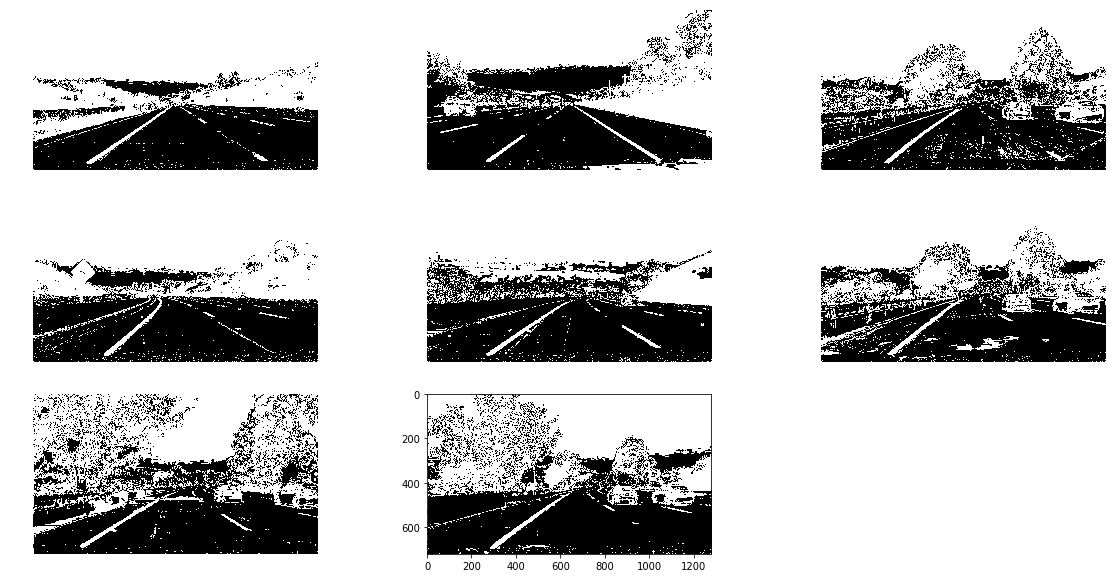

In [192]:
# Define a function that applies Sobel x or y,
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # 5) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image

    return sbinary


# Define a function that applies Sobel x and y,
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Calculate the magnitude
    magnitude = np.sqrt(sobelx ** 2 + sobely ** 2)

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_mag = np.uint8(255 * magnitude / np.max(magnitude))

    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1

    return binary_output


# Define a function that applies Sobel x and y,
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    graddir = np.arctan2(abs_sobely, abs_sobelx)

    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(graddir)
    binary_output[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1

    return binary_output

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def color_select(img, sthresh=(0, 255), vthresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_output = np.zeros_like(s_channel)
    s_output[(s_channel > sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_output = np.zeros_like(s_channel)
    v_output[(s_channel > vthresh[0]) & (s_channel <= vthresh[1])] = 1
    
    # define range of yellow and white color in HSV
    lower_yellow = np.array([12, 73, 73])
    upper_yellow = np.array([142, 255, 255])

    yellow_filter = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    binary_output = np.zeros_like(v_output)
    binary_output[((s_output ==1) & (v_output ==1)) | (yellow_filter == 255)] = 1
    
    return binary_output

def threshold(image, ksize=3):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(12, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(25, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(90, 255))
    c_binary = color_select(image, sthresh=(90,255), vthresh=(50,255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, np.pi/2))
    
    
    combined = np.zeros_like(image[:,:,0])
    combined[( (gradx == 1) | (c_binary == 1))] = 1

    return combined

# Lets test this out and see what it looks like in a few test images
plt.figure(figsize=(20,10))
i = 1
for filename in test_images:
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image = threshold(image, 5)
    plt.axis('off')
    plt.subplot(3, 3, i)
    plt.imshow(image, cmap='gray')
    i += 1
plt.show()


## Combining Techniques

Here we visualize everything I've covered so far. Generally speaking they looked "good enough", but I think there is still a lot of room for improvement.

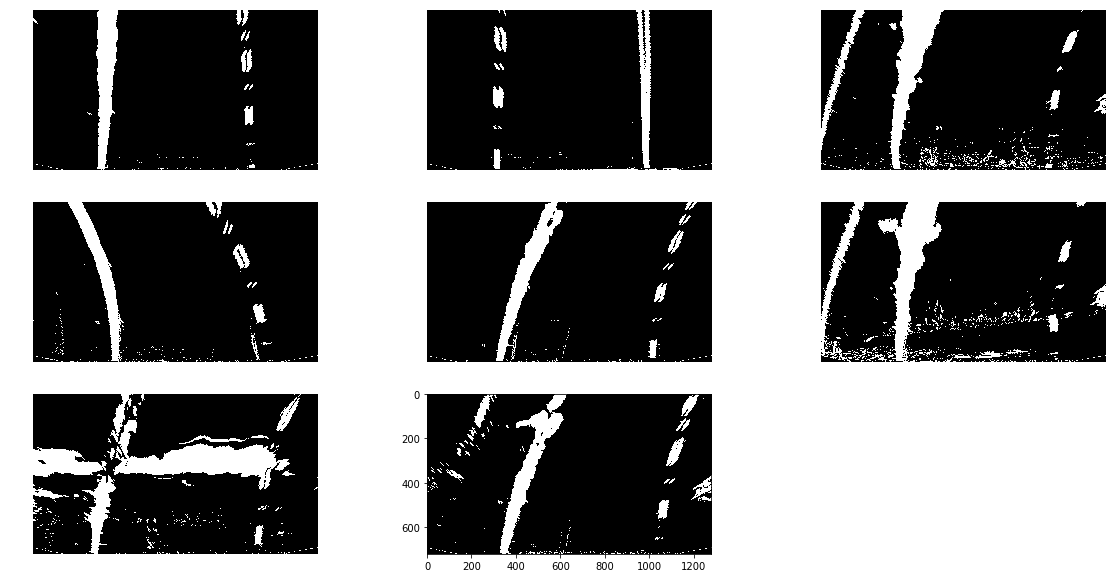

In [197]:
# Lets test this out and see what it looks like in a few test images
plt.figure(figsize=(20,10))
i = 1
offset = 300
for filename in test_images:
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Calling our calibration function first
    image = cal_undistort(image, objpoints, imgpoints)

    img_size = (image.shape[1], image.shape[0])
    # Arbitrarily picked coordinates from image to form mask
    src = np.float32([[590, 450], [690, 450], [1100, 720], [200, 720]])
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                     [img_size[0]-offset, img_size[1]],[offset, img_size[1]]]) 
    
    image, M, Minv = perspective_trasform(image, src, dst)
    image = threshold(image, 3)
    plt.axis('off')
    plt.subplot(3, 3, i)
    plt.imshow(image, cmap='gray')
    i += 1
plt.show()

## Finding the Lanes

This was probably the most challenging section for me. I decided to the use the convolving technique outlined in the class lectures as it seemed to be the most straight forward. I created a tracker class, covered in the office hours, to utilize information we gathered from previous images so we can have smoother transitions between images and less wiggling/jittering in our lane lines. 

In [227]:
class tracker():
    def __init__(self, margin, windows=9):
        self.left_fit = None
        self.right_fit = None
        self.left_fitx = None
        self.right_fitx = None
        self.leftx = None
        self.lefty = None
        self.rightx = None
        self.righty = None
        self.ploty = None
        self.margin = margin
        self.windows = windows
        
    def find_lanes(self, binary_warped):
        if self.left_fit == None or self.right_fit == None or self.ploty == None:
            return self.__find_lanes_uninitialized(binary_warped)
        else:
            return self.__find_lanes_initialized(binary_warped)
        
    def __find_lanes_uninitialized(self, binary_warped):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = self.windows
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        self.leftx = nonzerox[left_lane_inds]
        self.lefty = nonzeroy[left_lane_inds] 
        self.rightx = nonzerox[right_lane_inds]
        self.righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)

        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        
    def __find_lanes_initialized(self, binary_warped):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] - self.margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] + self.margin))) 
        right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] - self.margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] + self.margin)))  

        # Again, extract left and right line pixel positions
        self.leftx = nonzerox[left_lane_inds]
        self.lefty = nonzeroy[left_lane_inds] 
        self.rightx = nonzerox[right_lane_inds]
        self.righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        


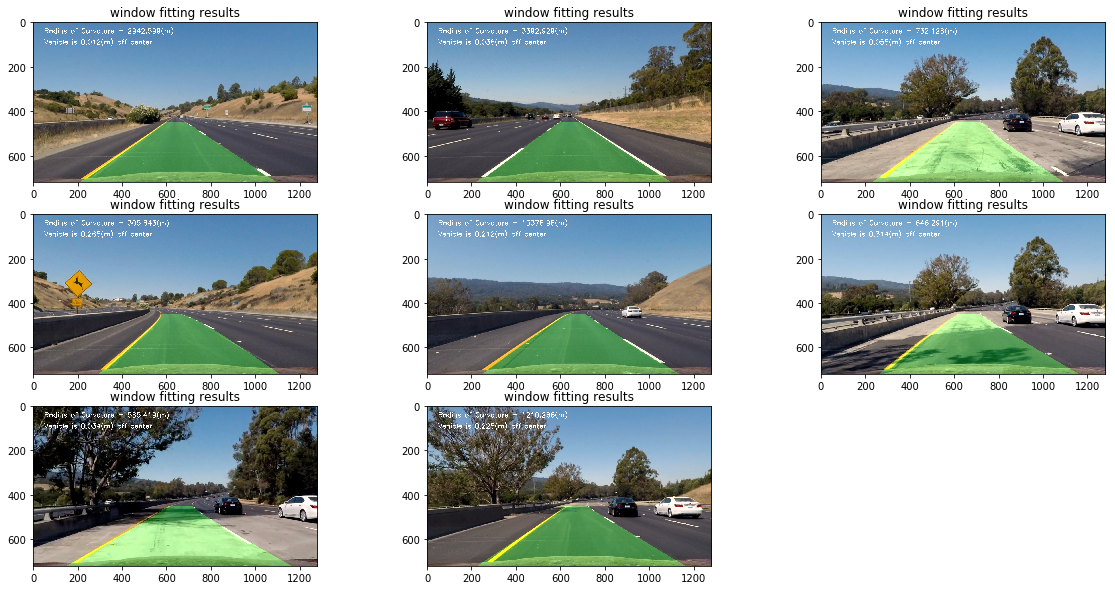

In [241]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching
lane_tracker = tracker(margin=margin)
    
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def process_image(image, show_windows=False, show_birds_eye=False):
    # Calling our calibration function first
    undistorted = cal_undistort(image, objpoints, imgpoints)
    img_size = (undistorted.shape[1], undistorted.shape[0])
    
    # Arbitrarily picked coordinates from image to form mask
    src = np.float32([[590, 450], [690, 450], [1100, 720], [200, 720]])
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                     [img_size[0]-offset, img_size[1]],[offset, img_size[1]]]) 
    
    transformed, M, Minv = perspective_trasform(undistorted, src, dst)
    warped = threshold(transformed, 3)
    
    
    lane_tracker.find_lanes(warped)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([lane_tracker.left_fitx, lane_tracker.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([lane_tracker.right_fitx, lane_tracker.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lane_tracker.lefty*ym_per_pix, lane_tracker.leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(lane_tracker.righty*ym_per_pix, lane_tracker.rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    y_eval = np.max(lane_tracker.ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    camera_center = (lane_tracker.left_fitx[-1] + lane_tracker.right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix

    #display the info 
    cv2.putText(result,'Radius of Curvature = '+str(round((left_curverad+right_curverad)/2,3))+'(m)',(50,50), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    cv2.putText(result,'Vehicle is '+str(round(center_diff,3))+'(m) off center',(50,100), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
   
    
    return result
    


plt.figure(figsize=(20,10))
i = 1
offset=200
for filename in test_images:
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = process_image(image)
    plt.subplot(3, 3, i)

    i += 1
    plt.imshow(result)
    plt.title('window fitting results')
plt.show()


## Apply it to the video!

In [239]:
from moviepy.editor import *
clip = VideoFileClip('project_video.mp4')
output = clip.fl_image(process_image)
output.write_videofile('output_track1.mp4')

[MoviePy] >>>> Building video output_track1.mp4
[MoviePy] Writing audio in output_track1TEMP_MPY_wvf_snd.mp3


100%|██████████| 1112/1112 [00:00<00:00, 2681.56it/s]

[MoviePy] Done.
[MoviePy] Writing video output_track1.mp4



100%|█████████▉| 1260/1261 [14:31<00:00,  1.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_track1.mp4 



## Conclusion
Given the current state of the pipeline, it definitely falls short when there a lot of variations in lighting across the road - whether its in the pavement itself or the light/shadows. You'll notice towards the end there is more wobbling as it transitions from dark to light to dark again. 

To fix or mitigate these issues more time needs to be spent refining the "Edge Detection" section to find a better combination that will remove more noise from our images. If you look at the birds-eye view of the lane after thresholding you still see a lot of noise. The better the noise removal the better our lane line detection will be. This was definitely extremely challenging for me.

I think that the sliding window algorithm for detecting lanes could use a lot more refinement as well as we cannot just depend on perfect edge detection. There will be times where there are gaps or missing lane line markers and the pipeline doesn't adequately handle those situations.



